# Multiband field photometric calibration

The purpose of this notebook is to experiment with a multiband photometric calibration for fields where this is available

In [1]:
from os import path
from pyDANDIA import metadata, crossmatch, gaia_phot_transforms
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import ODR, Data, Model
from astropy.table import Table, Column
import json

## OGLE-2024-BLG-0034

Photometry is available from gp and ip 1m0 datasets for this event, and the star catalogs have been crossmatched to produce a field crossmatch file.  

In [2]:
# Dataset
target_name = 'OGLE-2024-BLG-0034'
xmatch_file_path = '/Users/rstreet/OMEGAII/Data/OGLE-2024-BLG-0034/data/OGLE-2024-BLG-0034_field_crossmatch.fits'
gp_metadata_file = '/Users/rstreet/OMEGAII/Data/OGLE-2024-BLG-0034/data/OGLE-2024-BLG-0034_lsc-domb-1m09-fa04_gp/pyDANDIA_metadata.fits'
ip_metadata_file = '/Users/rstreet/OMEGAII/Data/OGLE-2024-BLG-0034/data/OGLE-2024-BLG-0034_lsc-domb-1m09-fa04_ip/pyDANDIA_metadata.fits'
gp_red_dir = 'OGLE-2024-BLG-0034_lsc-domb-1m09-fa04_gp'
ip_red_dir = 'OGLE-2024-BLG-0034_lsc-domb-1m09-fa04_ip'
gp_lc_file = '/Users/rstreet/OMEGAII/Data/OGLE-2024-BLG-0034/data/OGLE-2024-BLG-0034_lsc-domb-1m09-fa04_gp/star_50317_OGLE-2024-BLG-0034_gp_auto.dat'
ip_lc_file = '/Users/rstreet/OMEGAII/Data/OGLE-2024-BLG-0034/data/OGLE-2024-BLG-0034_lsc-domb-1m09-fa04_ip/star_59601_OGLE-2024-BLG-0034_ip_auto.dat'

In [3]:
# Load the crossmatch table for the field
xmatch = crossmatch.CrossMatchTable()
xmatch.load(xmatch_file_path)

However, the stars table in this file only contains calibrated instrumental magnitudes from the respective reference images, rather than the raw measurements. So we can load those from each dataset's original metadata.star_catalog table, and extract the relevant data columns using 
the cross-matched star index for the field.

In [4]:
# Load the metadata for each dataset
gp_metadata = metadata.MetaData()
gp_metadata.load_all_metadata(path.dirname(gp_metadata_file), path.basename(gp_metadata_file))

ip_metadata = metadata.MetaData()
ip_metadata.load_all_metadata(path.dirname(ip_metadata_file), path.basename(ip_metadata_file))

In [5]:
# Calculate Gaia magnitudes and uncertainties
(Gmag, Gmerr) = gaia_phot_transforms.gaia_flux_to_mag(xmatch.stars['phot_g_mean_flux'],
                                                      xmatch.stars['phot_g_mean_flux_error'],
                                                      passband="G")
(BPmag, BPmerr) = gaia_phot_transforms.gaia_flux_to_mag(xmatch.stars['phot_bp_mean_flux'],
                                                    xmatch.stars['phot_bp_mean_flux_error'],
                                                    passband="G_BP")
(RPmag, RPmerr) = gaia_phot_transforms.gaia_flux_to_mag(xmatch.stars['phot_rp_mean_flux'],
                                                    xmatch.stars['phot_rp_mean_flux_error'],
                                                    passband="G_RP")

In [6]:
# Identify stars with valid entries for calibrated photometry in the lsc-domb datasets.  
# This will be used to identify the indices of the valid stars rather than for the photometry
mag_col_gp = 'cal_g_mag_lsc_domb'
mag_col_ip = 'cal_i_mag_lsc_domb'
jdx = np.logical_and(xmatch.stars[mag_col_gp] > 0.0, xmatch.stars[mag_col_ip] > 0.0)
jdx = np.logical_and(jdx, Gmag > 0.0)
jdx = np.logical_and(jdx, BPmag > 0.0)
jdx = np.logical_and(jdx, RPmag > 0.0)
select_stars = np.where(jdx)[0]
print(str(len(select_stars)) + ' stars selected with valid photometry in both passbands and from Gaia DR3')

# Extract the indices of these stars in the respective datasets from the xmatch field index
gp_select_stars = xmatch.field_index[gp_red_dir+'_index'][select_stars] - 1
ip_select_stars = xmatch.field_index[ip_red_dir+'_index'][select_stars] - 1

# Identify the target, OGLE-2024-BLG-0034 in the data arrays
target_field_id = 59601
target_field_idx = target_field_id - 1

tselect = np.where(select_stars == target_field_idx)[0][0]
print('Target index in selected stars array: ' + str(tselect))

69416 stars selected with valid photometry in both passbands and from Gaia DR3
Target index in selected stars array: 32070


Now we can extract the instrumental magnitudes in each band and the Gaia photometry for the corresponding stars

In [7]:
phot = np.zeros((len(gp_select_stars),10))

phot[:,0] = gp_metadata.star_catalog[1]['ref_mag'][gp_select_stars]
phot[:,1] = gp_metadata.star_catalog[1]['ref_mag_error'][gp_select_stars]

phot[:,2] = ip_metadata.star_catalog[1]['ref_mag'][ip_select_stars]
phot[:,3] = ip_metadata.star_catalog[1]['ref_mag_error'][ip_select_stars]

phot[:,4] = Gmag[select_stars]
phot[:,5] = Gmerr[select_stars]
phot[:,6] = BPmag[select_stars]
phot[:,7] = BPmerr[select_stars]
phot[:,8] = RPmag[select_stars]
phot[:,9] = RPmerr[select_stars]

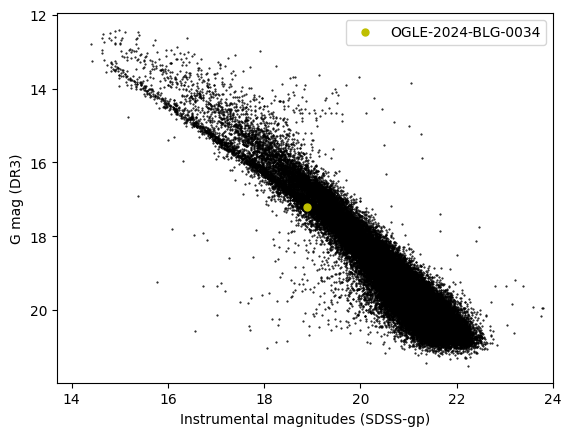

In [8]:
plt.plot(phot[:,0], phot[:,4], 'k.', markersize=1)
[xmin,xmax, ymin, ymax] = plt.axis()
plt.axis([xmin, 24.0, ymax, ymin])
plt.xlabel('Instrumental magnitudes (SDSS-gp)')
plt.ylabel('G mag (DR3)')

plt.plot(phot[tselect,0], phot[tselect,4], 'y.', markersize=10, label='OGLE-2024-BLG-0034')
plt.legend()

plt.show()

There is a 'fringe' of points above the main 'backbone' of data.  An example of one such star is Field index=1450 (Field ID = 1449). From the gp, ip metadata this star is:

In [9]:
star_field_idx = 2273
gp_idx = xmatch.field_index[gp_red_dir+'_index'][star_field_idx] - 1
ip_idx = xmatch.field_index[ip_red_dir+'_index'][star_field_idx] - 1
print('Example star field index = ' + str(star_field_idx) + ' corresponds to gp star index ' + str(gp_idx) + ' and ip star index ' + str(ip_idx))
print('Pixel locations: gp: ' + str(gp_metadata.star_catalog[1]['x'][gp_idx]) + ', ' + str(gp_metadata.star_catalog[1]['y'][gp_idx]))
print('Pixel locations: ip: ' + str(ip_metadata.star_catalog[1]['x'][ip_idx]) + ', ' + str(ip_metadata.star_catalog[1]['y'][ip_idx]))

Example star field index = 2273 corresponds to gp star index 1454 and ip star index 2273
Pixel locations: gp: 3562.6754487753615, 94.68216723081852
Pixel locations: ip: 3557.676085169386, 101.55232767508745


Visually inspecting the reference images for a few examples of stars in this fringe:

1450: Bright (though not saturated), close to edge of frame but not affected by it. 

6302: Moderately bright (not saturated), no issues

2273: Moderately bright (not saturated), no issues

It seems as though there is nothing wrong at the pixel data level, or the PSF fitting for these stars, so it looks like they are a distinct population in colour space, likely due to a combination of intrinsic colour and extinction/reddening.  

So we need to take the colour term into account for an accurate photometric calibration.  This is something the automatic pipeline cannot do since it is designed to reduce data in a single passband. 

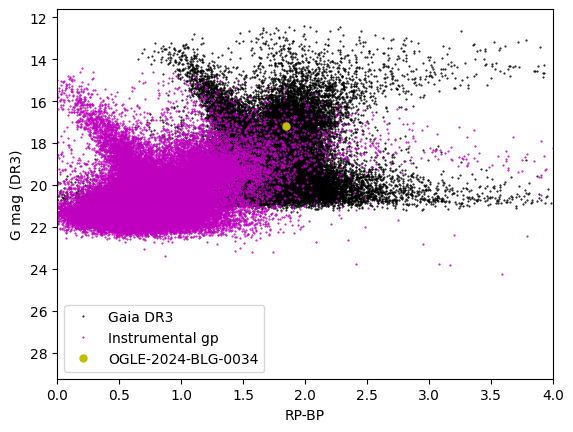

In [10]:
plt.plot(phot[:,6]-phot[:,8], phot[:,4], 'k.', markersize=1, label='Gaia DR3')
plt.plot(phot[:,0]-phot[:,2], phot[:,0], 'm.', markersize=1, label='Instrumental gp')

[xmin,xmax, ymin, ymax] = plt.axis()
plt.axis([0, 4.0, ymax, ymin])
plt.xlabel('RP-BP')
plt.ylabel('G mag (DR3)')

plt.plot(phot[tselect,6]-phot[tselect,8], phot[tselect,4], 'y.', markersize=10, label='OGLE-2024-BLG-0034')
plt.legend()

plt.show()

A photometric calibration including colour terms has the form:

gp_cal = a0 + a1*gp_inst + a2*[(gp_inst - ip_inst)]

In [11]:
def phot_func(p,x):
    return p[0] + p[1]*x[0] + p[2]*x[1]

In [12]:
def calc_transform(pinit, x, y, bprp):
    linear_model = Model(phot_func)
    dataset = Data(np.vstack((x, bprp)), y)
    odr_obj = ODR(dataset, linear_model, beta0=pinit)
    results = odr_obj.run()

    pfit = np.array([results.beta[0], results.beta[1], results.beta[2]])
    covar_fit = results.cov_beta*results.res_var

    return pfit, covar_fit

In [13]:
x = phot[:,0] # Instrumental gp mags
y = phot[:,4] # G mag DR3
colours = (phot[:,0] - phot[:,2])  # Using instrumental colours from reference image
#colours = (phot[:,6] - phot[:,8]) # Using Gaia colours
phot_calib = [0.0, 0.0, 0.0]

(phot_calib, calib_covar) = calc_transform(phot_calib, x, y, colours)
print('Parameters of phot calibration with colour terms: ' + repr(phot_calib))

Parameters of phot calibration with colour terms: array([-3.10753061,  1.11818163, -1.1662224 ])


To sanity check this photometric calibration, we can re-plot the CMD above, applying the calibration to the instrumental photometry to convert it to Gaia DR3.

TARGET:  18.88855662668262 1.1272678698006757


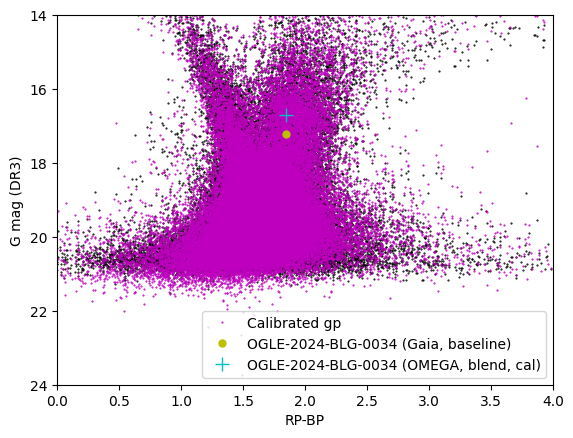

In [14]:
plt.plot(phot[:,6]-phot[:,8], phot[:,4], 'k.', markersize=1)

# Calibrate the instrumental gp data to G mag:
cal_gp = phot_func(phot_calib, np.vstack((phot[:,0],colours)))
plt.plot(phot[:,6]-phot[:,8], cal_gp, 'm.', markersize=1, label='Calibrated gp')

[xmin,xmax, ymin, ymax] = plt.axis()
plt.axis([0, 4.0, 24.0, 14.0])
plt.xlabel('RP-BP')
plt.ylabel('G mag (DR3)')

plt.plot(phot[tselect,6]-phot[tselect,8], phot[tselect,4], 'y.', markersize=10, label='OGLE-2024-BLG-0034 (Gaia, baseline)')
plt.plot(phot[tselect,6]-phot[tselect,8], cal_gp[tselect], 'c+', markersize=10, label='OGLE-2024-BLG-0034 (OMEGA, blend, cal)')
plt.legend()
print('TARGET: ',phot[tselect,0], colours[tselect])
plt.show()

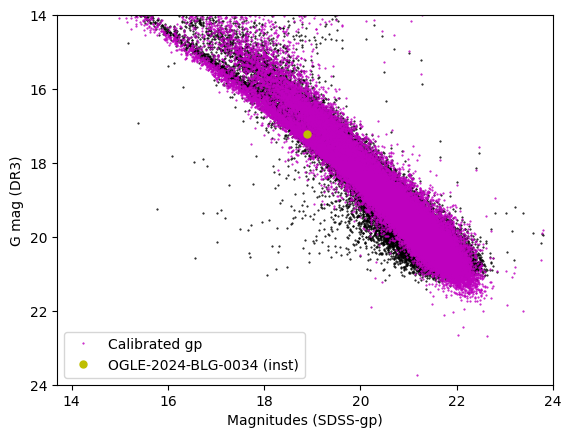

In [15]:
plt.plot(phot[:,0], phot[:,4], 'k.', markersize=1)
plt.plot(phot[:,0], cal_gp, 'm.', markersize=1, label='Calibrated gp')

[xmin,xmax, ymin, ymax] = plt.axis()
plt.axis([xmin, 24.0, 24, 14])
plt.xlabel('Magnitudes (SDSS-gp)')
plt.ylabel('G mag (DR3)')

plt.plot(phot[tselect,0], phot[tselect,4], 'y.', markersize=10, label='OGLE-2024-BLG-0034 (inst)')
plt.legend()

plt.show()

## Calibrating the timeseries photometry data

We need to output calibrated timeseries photometry in order to model the event, for which we need photometric uncertainties, which we can compute using the covarience matrix from the calibration.

In [16]:
def calc_calibrated_mags(fit_params, covar_fit, inst_mag, colours):
    """
    Function to calibrate instrumental magnitude and uncertainties using the precomputed photometric calibration parameters 
    and covarience matrix.  The inst_mag and colours arrays requires two columns for magnitude and uncertainity.
    """
    
    # Results array will be the same shape and indexing as the input photometry
    cal_mag = np.zeros(inst_mag.shape)

    # Apply the photometric calibration
    cal_mag[:,0] = phot_func(fit_params,np.vstack((inst_mag[:,0],colours[:,0])))
    
    # Calculate the uncertainties 
    ccalib = np.eye(5)
    ccalib[:3,:3] = covar_fit
    ccalib[3,3] = fit_params[0]**2
    ccalib[4,4] = fit_params[1]**2
    jac = np.c_[[1]*len(inst_mag), inst_mag[:,0], colours[:,0], inst_mag[:,1], colours[:,1]]
    errors = []
    for i in range(len(jac)):
        vect = []
        for j in range(len(ccalib)):
            vect.append(np.sum(ccalib[j]*jac[i]))
        errors.append(np.sum(vect*jac[i])**0.5)
    cal_mag[:,1] = errors

    # Mask values likely to be out of bound
    idx = np.where(phot[:,0] < 7.0)
    cal_mag[idx,0] = 0.0
    cal_mag[idx,1] = 0.0

    return cal_mag

Load the instrumental timeseries photometry produced by the pipeline

In [17]:
def load_extn_lc(file_path):
    """
    Function to load the full set of columns from a pyDANDIA lightcurve file in .dat format

    This includes columns:
    # HJD    Instrumental mag, mag_error   Calibrated mag, mag_error    Corrected mag, mag_error  QC Flag    Image
    """

    if not path.isfile(file_path):
        raise IOError(file_path + ' not found')

    data = []
    images = []
    line_list = open(file_path, 'r').readlines()
    for line in line_list:
        if '#' not in line:
            entries = line.replace('\n', '').split()
            datum = [float(entries[i]) for i in range(0,8,1)]
            data.append(datum)
            images.append(entries[8])
    data = np.array(data)

    float_cols = ['HJD', 'Instrumental mag', 'Inst_mag_error', 'Calibrated mag', 'Cal_mag_error', 'Corrected mag', 'Corr_mag_error', 'QC Flag']
    column_list = [Column(name=float_cols[i], data=data[:,i]) for i in range(0,8,1)]
    column_list.append(Column(name='Image', data=images))
    
    return Table(column_list)


In [18]:
gp_lc = load_extn_lc(gp_lc_file)
ip_lc = load_extn_lc(ip_lc_file)

Now we can use the calibration and functions above to calculate revised calibrated magnitudes, and output the updated lightcurves. 

In [19]:
# SDSS-gp lightcurve
gp_phot = np.c_[(gp_lc['Instrumental mag'].data,gp_lc['Inst_mag_error'].data)]
colours = np.zeros(gp_phot.shape)
colours[:,0] = np.array([phot[tselect,0] - phot[tselect,2]]*len(gp_phot)) # Target colour in reference image used for all images
sig_col = np.sqrt(phot[tselect,1]*phot[tselect,1] + phot[tselect,3]*phot[tselect,3])
colours[:,1] = np.array([sig_col]*len(gp_phot))
gp_phot = calc_calibrated_mags(phot_calib, calib_covar, gp_phot, colours)

# SDSS-ip lightcurve
ip_phot = np.c_[(ip_lc['Instrumental mag'].data,ip_lc['Inst_mag_error'].data)]
colours = np.zeros(ip_phot.shape)
colours[:,0] = np.array([phot[tselect,0] - phot[tselect,2]]*len(ip_phot)) # Target colour in reference image used for all images
sig_col = np.sqrt(phot[tselect,1]*phot[tselect,1] + phot[tselect,3]*phot[tselect,3])
colours[:,1] = np.array([sig_col]*len(ip_phot))
ip_phot = calc_calibrated_mags(phot_calib, calib_covar, ip_phot, colours)

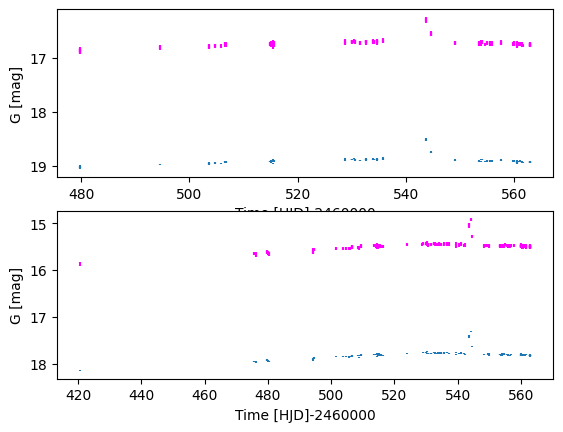

In [20]:
fig, axs = plt.subplots(2,1)

# Gp- lightcurve
axs[0].errorbar(
    gp_lc['HJD']-2460000.0, 
    gp_lc['Instrumental mag'], 
    yerr=gp_lc['Inst_mag_error'], 
    marker='.', mfc='k', markersize=1, fmt='none',
    label='Instrumental'
)
axs[0].errorbar(
    gp_lc['HJD']-2460000.0, 
    gp_phot[:,0], 
    yerr=gp_phot[:,1], 
    marker='.', markersize=1, 
    color='magenta',
    fmt='none', 
    label='Calibrated'
)

axs[0].set_xlabel('Time [HJD]-2460000')
axs[0].set_ylabel('G [mag]')

[xmin, xmax, ymin, ymax] = axs[0].axis()
axs[0].axis([xmin, xmax, ymax, ymin])
#axs[0].legend()

# Ip - lightcurve
axs[1].errorbar(
    ip_lc['HJD']-2460000.0, 
    ip_lc['Instrumental mag'], 
    yerr=ip_lc['Inst_mag_error'], 
    marker='.', mfc='k', markersize=1, fmt='none',
    label='Instrumental'
)
axs[1].errorbar(
    ip_lc['HJD']-2460000.0, 
    ip_phot[:,0], 
    yerr=ip_phot[:,1], 
    marker='.', markersize=1, 
    color='magenta',
    fmt='none', 
    label='Calibrated'
)

axs[1].set_xlabel('Time [HJD]-2460000')
axs[1].set_ylabel('G [mag]')

[xmin, xmax, ymin, ymax] = axs[1].axis()
axs[1].axis([xmin, xmax, ymax, ymin])
#axs[1].legend()

plt.show()

So lastly we can replace the lightcurve's orginal calibrated magnitude and uncertainty columns with the newly calibrated data, and output to file.

In [21]:
def output_lc(lc_table, file_path):

    with open(file_path, 'w') as f:
        f.write('# HJD    Instrumental mag, mag_error   Calibrated mag, mag_error    Corrected mag, mag_error  QC Flag    Image\n')
        for i in range(0,len(lc_table),1):
            f.write(str(lc_table['HJD'][i]) + ' ' 
                    + str(lc_table['Instrumental mag'][i]) + ' '
                    + str(lc_table['Inst_mag_error'][i]) + ' '
                    + str(lc_table['Calibrated mag'][i]) + ' ' 
                    + str(lc_table['Cal_mag_error'][i]) + ' ' 
                    + str(lc_table['Corrected mag'][i]) + ' ' 
                    + str(lc_table['Corr_mag_error'][i]) + ' ' 
                    + str(lc_table['QC Flag'][i]) + ' ' 
                    + lc_table['Image'][i] + '\n')
        f.close()


In [22]:
gp_lc['Calibrated mag'] = gp_phot[:,0]
gp_lc['Cal_mag_error'] = gp_phot[:,1]

lc_file_new = gp_lc_file.replace('.dat', '_new.dat')
output_lc(gp_lc, lc_file_new)

ip_lc['Calibrated mag'] = ip_phot[:,0] 
ip_lc['Cal_mag_error'] = ip_phot[:,1] 

lc_file_new = ip_lc_file.replace('.dat', '_new.dat')
output_lc(ip_lc, lc_file_new)

We also need to output the photometric calibration details

In [23]:
file_path = path.join(path.dirname(xmatch_file_path), 'phot_calibration.json')
calib = {
    'a0': phot_calib[0],
    'a1': phot_calib[1],
    'a2': phot_calib[2],
    'covar': calib_covar.tolist()
}
with open(file_path, "w") as f:
    json.dump(calib, f, indent=4)


Output the calibrated CMD data to file

In [26]:
# Calculate the calibrated magnitude and uncertainty for all stars in the reference image
gp_phot = np.c_[(phot[:,0], phot[:,1])]
colours = np.zeros(gp_phot.shape)
colours[:,0] = np.array([phot[:,0] - phot[:,2]])
sig_col = np.sqrt(phot[:,1]*phot[:,1] + phot[:,3]*phot[:,3])
colours[:,1] = np.array([sig_col])
gp_phot = calc_calibrated_mags(phot_calib, calib_covar, gp_phot, colours)

file_path = path.join(path.dirname(xmatch_file_path), 'cal_cmd.dat')
with open(file_path, 'w') as f:
    f.write('# Colour-magnitude Data for OMEGA-II observations of ' + target_name + '\n')
    f.write('# Calibrated to Gaia DR3 Gmag and BP-RP colours\n')
    f.write('# Target ' + target_name + ' has star_field_id=' + str(target_field_id) + '\n')
    f.write('#\n')
    f.write('# star_field_ID  G [mag] G mag error   BP-RP [mag]  BP-RP error\n')
    for j in range(0,len(gp_phot),1):
        f.write(
            str(select_stars[j]+1) + '  ' 
            + str(gp_phot[j,0]) + '  ' 
            + str(gp_phot[j,1]) + '  ' 
            + str(colours[j,0]) + '  ' 
            + str(colours[j,1]) + '\n')
    f.close()